In [ ]:
import pandas as pd
import json
import numpy as np

from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
import tensorflow as tf

# import packages for hyperparameters tuning
import optuna

In [3]:
model_for_testing = 'protTrans'
df = pd.read_csv('../Datasets/My_Dataset/proteins_embeddings_' + model_for_testing + '_annotated.csv', index_col=0, dtype={'your_column': 'float32'})

# convert residues to one-hot encode
df_res = pd.get_dummies(df['residue_1l'])
# Convert boolean values to numeric values
df_res = df_res.astype(int)

df = df.merge(df_res, left_index=True, right_index=True, how='inner')
df.insert(len(df.columns)-1, 'is_IBS', df.pop('is_IBS'))
df.head(5)

f = open('..s/Datasets/My_Dataset/split_proteins.json')
dict_proteins_split = json.load(f)
f.close()

df_train = df[df.uniprot_id.isin(dict_proteins_split['train'])]
df_test = df[df.uniprot_id.isin(dict_proteins_split['test'])]
df_val = df[df.uniprot_id.isin(dict_proteins_split['val'])]

positive_samples = df_train['is_IBS'].sum()
negative_samples = len(df_train) - positive_samples

ratio = negative_samples / positive_samples

X_train, y_train = df_train.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_train['is_IBS']
X_test, y_test = df_test.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_test['is_IBS']
X_val, y_val = df_val.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_val['is_IBS']

import gc

del df, df_train, df_test, df_val, df_res
gc.collect()

X_train, y_train = X_train.values, y_train.values
X_test, y_test = X_test.values, y_test.values

### Optimize XGBoost

In [ ]:
xgb_clf = XGBClassifier()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

trials = {}
# 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "gamma": trial.suggest_float("gamma", 0.7, 1.0, step=0.1),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 31, step=2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", ratio-5, ratio+5),
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)

    f1 =  f1_score(y_val, pred_labels)
    mcc =  matthews_corrcoef(y_val, pred_labels)
    conf_matrix = confusion_matrix(y_val, pred_labels)

    trials[trial.number] = [f1, mcc, conf_matrix]    
    return f1

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

In [16]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.5014343086632244
  Params: 
    learning_rate: 0.018532546571990664
    booster: gbtree
    gamma: 0.7999999999999999
    lambda: 0.00010690298719347456
    reg_alpha: 9.353729121385786
    subsample: 0.6835366299983335
    colsample_bytree: 0.7145795902754652
    max_depth: 11
    min_child_weight: 4
    scale_pos_weight: 38.948239592913026


In [19]:
xgb_clf = XGBClassifier(objective='binary:logistic', **trial.params, n_jobs=-1, random_state=42)

xgb_clf.fit(X_train, y_train)

# evaluate model on the traindataset
ypred = xgb_clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.581 
MCC: 0.526 
      0    1
0  6450  462
1   321  543


### Optimize BalancedRandomForest

In [ ]:
import sklearn.model_selection

trials = {}
# 1. Define an objective function to be maximized.
def objective(trial):
    params_brf = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 1, 31, step=2),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0, log=True),
    }

    brf = BalancedRandomForestClassifier(replacement=True, sampling_strategy= "all", **params_brf, n_jobs=-1)
    score = sklearn.model_selection.cross_val_score(brf, X_train, y_train, scoring="f1", n_jobs=-1, cv=3).mean()

    return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

In [32]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.34060937812551556
  Params: 
    n_estimators: 476
    criterion: gini
    max_depth: 31
    min_samples_split: 9
    min_samples_leaf: 1
    max_features: 0.10002741468568423


In [34]:
trial = study.best_trial
brf_clf = BalancedRandomForestClassifier(replacement=True, sampling_strategy= "all", n_jobs=-1, **trial.params)
brf_clf.fit(X_train, y_train)
ypred = brf_clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.526 
MCC: 0.470 
Balanced accuracy: 0.790 
      0    1
0  6084  828
1   260  604


### Optimize SLP

In [ ]:
def objective(trial):
    # Define hyperparameters to be optimized
    params = {
        'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes', 1, 1000),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'epochs': 20,
    }

    # Build the MLP model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=params['hidden_layer_sizes'], activation=params['activation'], input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Assuming binary classification

    # Compile the model
    if params['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the training set
    model.fit(X_train, y_train, epochs=params['epochs'], verbose=0)

    # Make predictions on the validation set
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate accuracy on the validation set
    f1 = f1_score(y_val, y_pred)

    return f1  # Optimize for accuracy, so minimize the error

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

In [6]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.5164923572003217
  Params: 
    hidden_layer_sizes: 776
    activation: relu
    optimizer: adam
    learning_rate: 0.0009146523695170536


In [8]:
metrics = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

# Build the final model with the best hyperparameters on the entire training set
final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=776, activation='relu', input_dim=X_train.shape[1]))
final_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Assuming binary classification

# Compile the final model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009146523695170536), loss='binary_crossentropy', metrics=metrics)

# Train the final model on the entire training set
final_model.fit(X_train, y_train, epochs=20)

ypred = final_model.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred > 0.5))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred > 0.5))

cm = confusion_matrix(y_test, ypred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

Epoch 1/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0514 - tp: 4260.0000 - fp: 1611.0000 - tn: 287372.0000 - fn: 4052.0000 - precision: 0.7256 - recall: 0.5125
Epoch 2/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0326 - tp: 5984.0000 - fp: 1379.0000 - tn: 287604.0000 - fn: 2328.0000 - precision: 0.8127 - recall: 0.7199
Epoch 3/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0225 - tp: 6801.0000 - fp: 1001.0000 - tn: 287982.0000 - fn: 1511.0000 - precision: 0.8717 - recall: 0.8182
Epoch 4/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0159 - tp: 7336.0000 - fp: 677.0000 - tn: 288306.0000 - fn: 976.0000 - precision: 0.9155 - recall: 0.8826
Epoch 5/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0116 - tp: 7634.0000 - fp: 510.0000 - tn: 288473.0000 - fn: 678.0000 - precision: 0.9374 - recall: 0.9184
Epoch 6/20
9291/9291 [==============================] - 22s 2ms/step 

### Optimize MLP

In [ ]:
def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 4)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    num_hidden = trial.suggest_int("n_units_l_input", 4, 512, log=True)
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            num_hidden,
            input_shape=(X_train.shape[-1],),
            activation=trial.suggest_categorical('activation_input', ['relu', 'tanh', 'sigmoid']),
        )
    )
    model.add(tf.keras.layers.Flatten())

    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation=trial.suggest_categorical('activation_{}'.format(i), ['relu', 'tanh', 'sigmoid']),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay), activation="sigmoid")
    )
    return model

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn(model, optimizer, X, y, trial):    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall(), 
                           tf.keras.metrics.F1Score(name='f1_score')])
    
    y = tf.cast(y, tf.float32)

    model.fit(X, y, 
              epochs=trial.suggest_int("epochs", 10, 30), 
              batch_size=trial.suggest_int("batch_size", 128, 512))

    
def objective(trial):

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/GPU:0"):
        # for _ in range(20):
        learn(model, optimizer, X_train, y_train, trial)

        # Make predictions on the validation set
        y_pred_proba = model.predict(X_val.values)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate F1 score on the validation set
        f1 = f1_score(y_val.values, y_pred)

    # Return last validation accuracy.
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [13]:
print("Number of trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of trials:  50
Best trial:
  Value: 0.6041055718475073
  Params: 
    n_layers: 3
    weight_decay: 2.6955177810398497e-08
    n_units_l_input: 274
    activation_input: relu
    n_units_l0: 42
    activation_0: tanh
    n_units_l1: 53
    activation_1: relu
    n_units_l2: 49
    activation_2: tanh
    optimizer: Adam
    adam_learning_rate: 0.0018389654970221772
    epochs: 14
    batch_size: 283


In [19]:
params = {
  'n_layers': 3,
  'weight_decay': 2.6955177810398497e-08,
  'n_units_l_input': 274,
  'activation_input': 'relu',
  'n_units_l0': 42,
  'activation_0': 'tanh',
  'n_units_l1': 53,
  'activation_1': 'relu',
  'n_units_l2': 49,
  'activation_2': 'tanh',
  'optimizer': 'Adam',
  'adam_learning_rate': 0.0018389654970221772,
  'epochs': 14,
  'batch_size': 283,
}

In [20]:
model_mlp = tf.keras.Sequential()

model_mlp.add(tf.keras.layers.Dense(params['n_units_l_input'], 
                                    input_shape=(X_train.shape[-1],), 
                                    activation=params['activation_input']))
model_mlp.add(tf.keras.layers.Flatten())

for i in range(params['n_layers']):
  model_mlp.add(tf.keras.layers.Dense(
                params['n_units_l{}'.format(i)],
                activation=params['activation_{}'.format(i)],
                kernel_regularizer=tf.keras.regularizers.l2(params['weight_decay']))
            )
model_mlp.add(
        tf.keras.layers.Dense(1, 
                              kernel_regularizer=tf.keras.regularizers.l2(params['weight_decay']), 
                              activation="sigmoid")
    )


model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['adam_learning_rate']),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall()])
y = tf.cast(y_train, tf.float32)

model_mlp.fit(X_train, y, 
              epochs=params['epochs'], 
              batch_size=params['batch_size'])

Epoch 1/14


/home/dimitra/miniconda3/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1051/1051 [==============================] - 2s 2ms/step - loss: 0.0533 - precision_6: 0.6947 - recall_6: 0.4975
Epoch 2/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0332 - precision_6: 0.7901 - recall_6: 0.7156
Epoch 3/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0251 - precision_6: 0.8273 - recall_6: 0.7980
Epoch 4/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0198 - precision_6: 0.8627 - recall_6: 0.8493
Epoch 5/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0161 - precision_6: 0.8895 - recall_6: 0.8793
Epoch 6/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0134 - precision_6: 0.9069 - recall_6: 0.9039
Epoch 7/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0116 - precision_6: 0.9186 - recall_6: 0.9175
Epoch 8/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0098 - precision_6: 0.9303 - recall_6: 0.9340
Epoch 9/14
1051/105

In [21]:
 # Make predictions on the validation set
y_pred_proba = model_mlp.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print('F1 score: %.3f ' % f1_score(y_test, y_pred > 0.5))
print('MCC: %.3f ' % matthews_corrcoef(y_test, y_pred > 0.5))

cm = confusion_matrix(y_test, y_pred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

243/243 [==============================] - 0s 410us/step
F1 score: 0.680 
MCC: 0.647 
      0    1
0  6730  182
1   325  539


In [22]:
model_mlp.save("best_model_protTrans_new")

INFO:tensorflow:Assets written to: best_model_protTrans_new/assets


INFO:tensorflow:Assets written to: best_model_protTrans_new/assets


### Plot Tensorflow model

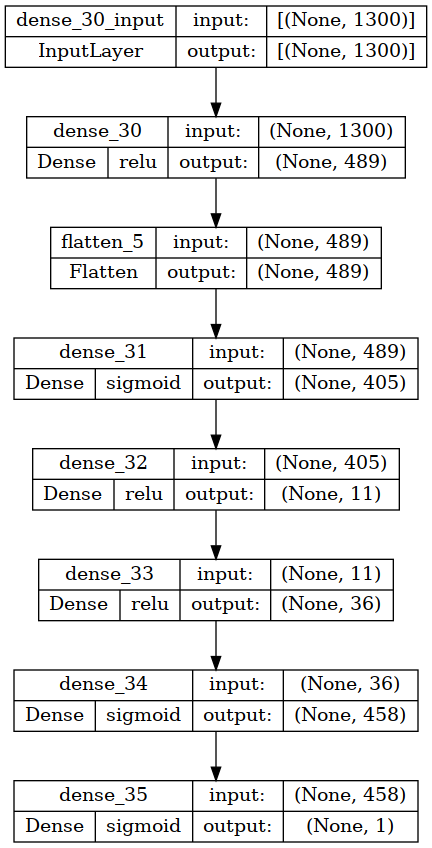

In [3]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import F1Score
import tensorflow as tf

model_for_testing = 'esm_new'
model = tf.keras.models.load_model('../models/best_model_esm_new')

plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)